# Capacity allocation

## 0. Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from benchmarks.generator import get_revenue_behavior, get_revenue_behavior_deprecated
from benchmarks.robin_railway import RevenueMaximization
from benchmarks.utils import sns_box_plot, sns_line_plot, int_input, get_schedule_from_supply, infer_line_stations, get_services_by_tsp_df, plot_marey_chart
from src.entities import GSA, Solution

from robin.supply.saver.entities import SupplySaver
from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Service, Supply

from pathlib import Path
from typing import Any, List, Mapping, Tuple, Union
import shutil

In [2]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/generator/supply_dummy.yml')
supply_save_path = '../configs/mealpy/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(generator_save_path.parent).exists():
    shutil.rmtree(generator_save_path.parent)

Path(generator_save_path.parent).mkdir(parents=True)

if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

#if Path(figures).exists():
#    shutil.rmtree(figures)
#Path(figures).mkdir(parents=True)

In [3]:
seed = 21

if generator_config_path:
    n_services = int_input("Number of services to generate: ")
    generator = ServiceGenerator(supply_config_path=supply_config_path)
    _ = generator.generate(output_path=generator_save_path,
                           path_config=generator_config_path,
                           n_services=n_services,
                           seed=seed)
    print(f'Number of service requests generated: {len(_)}')

Number of service requests generated: 50


In [4]:
supply = Supply.from_yaml(generator_save_path)
tsp_df = get_services_by_tsp_df(supply.services)

print(tsp_df)

     Number of Services
RU2                   7
RU3                   9
RU1                  10
RU4                  14
RU5                  10


In [5]:
print("Services: ", len(supply.services))
requested_schedule = get_schedule_from_supply(generator_save_path)
revenue_behavior = get_revenue_behavior_deprecated(supply)
lines = list(supply.lines)
line = infer_line_stations(lines)

Services:  50


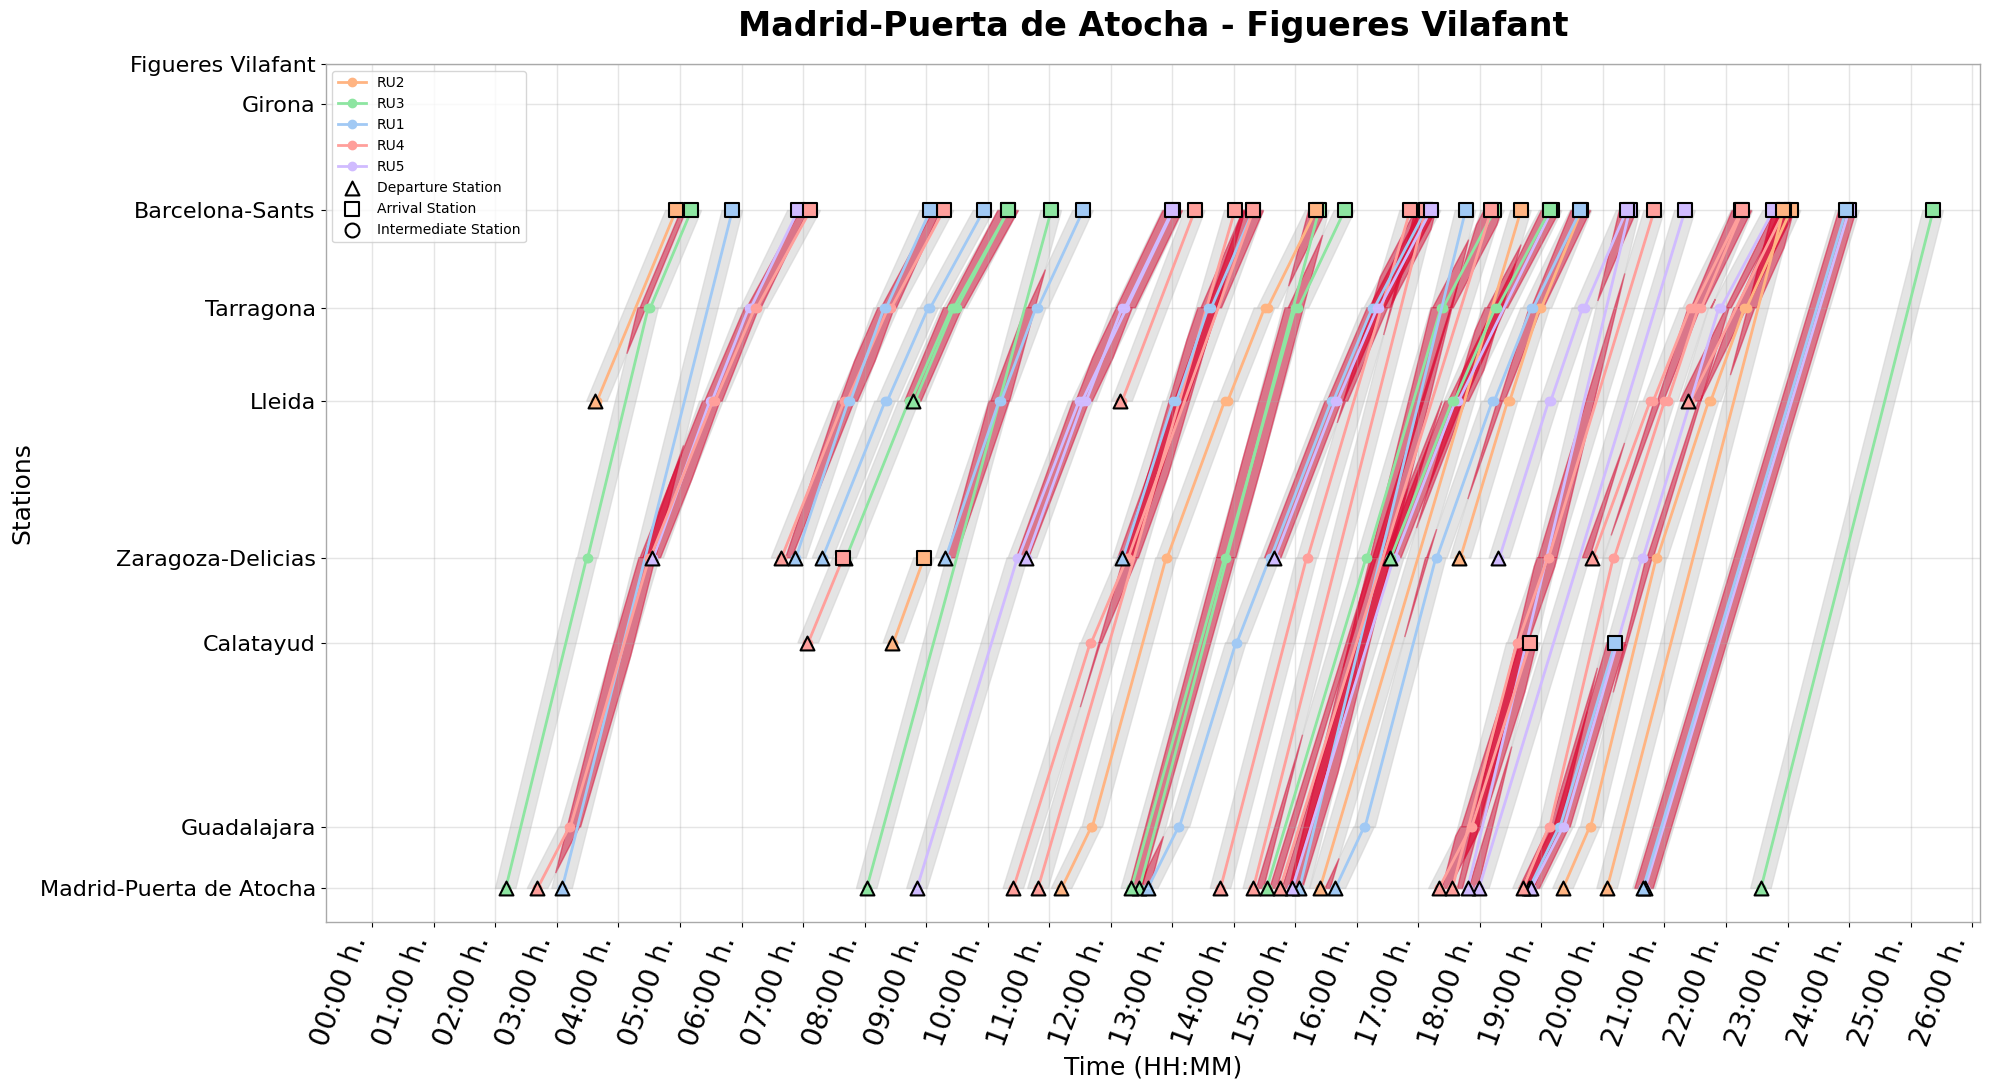

In [6]:
import datetime

date = datetime.datetime.strptime('2025-06-25', '%Y-%m-%d').date()
plot_marey_chart(
    supply=supply,
    date=date,
    save_path='../figures/escim2025/'
)

## 1. Mealpy

In [7]:
from src.timetabling_problem import MPTT

mptt = MPTT(requested_schedule=requested_schedule,
            revenue_behavior=revenue_behavior,
            line=line,
            safe_headway=10)

In [8]:
from mealpy.evolutionary_based import DE, ES, GA
from mealpy.swarm_based import ABC, ACOR, GWO, PSO, WOA
from mealpy.physics_based import SA

mp_algos = {
    "Genetic Algorithm": {'callable': GA.BaseGA, 'epoch': 500, 'pop_size': 70},
    "Particle Swarm Optimization": {'callable': PSO.OriginalPSO, 'epoch': 500, 'pop_size': 80},
    "Simulated Annealing": {'callable': SA.OriginalSA ,'epoch': 4500, 'pop_size': 1},
    "Differential Evolution": {'callable': DE.OriginalDE, 'epoch': 300, 'pop_size': 100},
    "Ant Colony Optimization Continuous (ACOR)": {'callable': ACOR.OriginalACOR, 'epoch': 500, 'pop_size': 10},
    "Covariance Matrix Adaptation Evolution Strategy": {'callable': ES.CMA_ES, 'epoch': 250, 'pop_size': 80},
    "Artificial Bee Colony": {'callable': ABC.OriginalABC, 'epoch': 450, 'pop_size': 60},
    "Grey Wolf Optimizer": {'callable': GWO.OriginalGWO, 'epoch': 500, 'pop_size': 100},
    "Whale Optimization Algorithm": {'callable': WOA.OriginalWOA, 'epoch': 400, 'pop_size': 80},
    "Hybrid Grey Wolf - Whale Optimization Algorithm": {'callable': GWO.GWO_WOA, 'epoch': 450, 'pop_size': 50}
}

In [9]:
reports_path = Path('../reports/mealpy/timetabling/')

In [12]:
%%capture

import time

from hyperopt import fmin, tpe, Trials, hp
from mealpy import IntegerVar

elapsed_times = {}

# 0. Problem formulation
lb, ub = zip(*mptt.boundaries.real)

problem = {
    "obj_func": mptt.objective_function,
    "bounds": IntegerVar(lb=lb, ub=ub),
    "minmax": "max",
    "save_population": False
}

def objective(params, algo_name, algo, seed):
    num_epochs = int(params['num_epochs'])
    num_individuals = int(np.ceil(params['num_individuals']) // 2 * 2)
    
    if algo_name == "Simulated Annealing":
        optimizer = algo(epoch=num_epochs*num_individuals)
        optimizer.solve(problem, seed=seed)
    else:
        optimizer = algo(epoch=num_epochs, pop_size=num_individuals)
        optimizer.solve(problem, seed=seed)

    return -optimizer.history.list_global_best[-1].target.fitness

# Search space
space = {
    'num_epochs': hp.quniform('num_epochs', 50, 500, 50),
    'num_individuals': hp.quniform('num_individuals', 10, 100, 10)
}

seed_initializer = 29
df_hparams = pd.DataFrame(columns=['Algo', 'Epoch', 'Ind'])

# Iterate through each algorithm with a progress bar
for algo_name, algo in mp_algos.items():
    print(f"Processing {algo_name}")

    start_time = time.time()
    
    np.random.seed(seed_initializer)
    trials = Trials()
    hp_seed = np.random.randint(0, 1000)
    rstate = np.random.default_rng(hp_seed)

    best = fmin(
        fn=lambda args: objective(args, algo_name, algo, hp_seed), 
        space=space, 
        algo=tpe.suggest, 
        max_evals=100, 
        trials=trials, 
        rstate=rstate,
        show_progressbar=False
    )

    hp_row = [algo_name, best['num_epochs'], best['num_individuals']]
    df_hparams.loc[len(df_hparams)] = hp_row
    
    # Save intermediate results to CSV
    df_hparams.to_csv(reports_path / "hyperparams_results_six.csv", sep=";", index=False)
    
    elapsed_times[algo_name] = time.time() - start_time

print(df_hparams)

In [13]:
df_hparams

,Algo,Epoch,Ind
0,Differential Evolution,300.0,100.0
1,Covariance Matrix Adaptation Evolution Strategy,250.0,80.0
2,Artificial Bee Colony,450.0,60.0
3,Grey Wolf Optimizer,500.0,100.0
4,Whale Optimization Algorithm,400.0,80.0
5,Hybrid Grey Wolf - Whale Optimization Algorithm,450.0,50.0


In [ ]:
from IPython.display import clear_output

from mealpy import IntegerVar

runs = 5
seed_initializer = 29

# 0. Problem formulation
lb, ub = zip(*mptt.boundaries.real)

problem = {"obj_func": mptt.objective_function,
           "bounds": IntegerVar(lb=lb,
                              ub=ub),
           "minmax": "max",
           "save_population": True}

# 1. Iter algorithms
for algo_name, algo_info in mp_algos.items():
    df_history = pd.DataFrame()
    df_population = pd.DataFrame()
    algo = algo_info['callable']
    epoch = algo_info['epoch']
    pop_size = algo_info['pop_size']
    
    # Re-initialize seed
    np.random.seed(seed_initializer)
    
    print(f"Running {algo_name}")
    for r in range(1, runs+1):
        print("\tRun: ", r)
        
        run_seed = np.random.randint(0, 1000)
        
        # Run algorithm
        if algo_name == "Simulated Annealing":
            optimizer = algo(epoch=epoch*pop_size)
            optimizer.solve(problem, seed=run_seed)
        else:
            optimizer = algo(epoch=epoch, pop_size=pop_size)
            optimizer.solve(problem, seed=run_seed)
            
        # Build run history dataframe
        columns = ['Algo', 'Iteration', 'Fitness', 'ExecutionTime', 'Discrete', 'Real', 
                   'Diversity', 'Exploitation', 'Exploration']
        run_history = pd.DataFrame(columns=columns)
        
        # Save optimizer history to dataframe
        for i, data in enumerate(optimizer.history.list_global_best):
            mptt.update_schedule(data.solution)
            run_history.loc[i] = [algo_name,
                                  i, 
                                  data.target.fitness,
                                  optimizer.history.list_epoch_time[i],
                                  mptt.get_heuristic_schedule_old(),
                                  data.solution,
                                  optimizer.history.list_diversity[i],
                                  optimizer.history.list_exploitation[i],
                                  optimizer.history.list_exploration[i]]
    
        run_history.insert(0, "Run", r)
        df_history = pd.concat([df_history, run_history], axis=0)
        
        # Population dataframe
        if algo_name == "Simulated Annealing":
            continue
        
        population_colums = [f'real_{i}' for i in range(pop_size)] + [f'discrete_{i}' for i in range(pop_size)]
        population_colums.insert(0, 'Iteration')
        run_population = pd.DataFrame(columns=population_colums)
        
        for i, pop_epoch in enumerate(optimizer.history.list_population):
            population_row = [i]
            real = []
            discrete = [] 
            for individual in pop_epoch:
                mptt.update_schedule(individual.solution)
                real.append(individual.solution)
                discrete.append(mptt.get_heuristic_schedule_old())
            
            population_row = [i, *real, *discrete]
            run_population.loc[len(run_population)] = population_row
        
        run_population.insert(0, "Run", r)
        run_population.insert(1, "Algo", algo_name)
        df_population = pd.concat([df_population, run_population], axis=0)

    df_history.to_csv(reports_path / f'df_history_50_opti_{algo_name}.csv', sep=";", index=False)
    df_population.to_csv(reports_path / f'df_population_50_opti_{algo_name}.csv', sep=";", index=False)
    clear_output()

2025/06/04 11:37:35 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: Solving single objective optimization problem.


Running Genetic Algorithm
	Run:  1


2025/06/04 11:37:37 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2870.5570989602716, Global best: 2870.5570989602716, Runtime: 1.39859 seconds
2025/06/04 11:37:39 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 3298.881312030799, Global best: 3298.881312030799, Runtime: 1.48922 seconds
2025/06/04 11:37:40 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 3445.6069219907304, Global best: 3445.6069219907304, Runtime: 1.45606 seconds
2025/06/04 11:37:42 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3779.2077544849913, Global best: 3779.2077544849913, Runtime: 1.41887 seconds
2025/06/04 11:37:43 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 4090.1406980209154, Global best: 4090.1406980209154, Runtime: 1.42018 seconds
2025/06/04 11:37:45 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, 

## 2. Results analysis

In [10]:
reports_path = Path('../reports/mealpy/')

In [15]:
df_history.to_csv(reports_path / 'df_history_5_seed.csv', sep=";", index=False)

In [16]:
df_population.to_csv(reports_path / 'df_population_5_seed.csv', sep=";", index=False)

In [36]:
df_history = pd.read_csv(reports_path / 'df_history_5_seed.csv', sep=";")
df_population = pd.read_csv(reports_path / 'df_population_5_seed.csv', sep=";")

In [30]:
df_history

,Run,Algo,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration
0,1,Genetic Algorithm,0,2459.878405,0.246457,[False True False True True True True Fal...,[1070. 1114. 1143. 867. 970. 1046. 902. 82...,3.209825,0.000000,100.000000
1,1,Genetic Algorithm,1,2460.308339,0.243454,[False True False True True True True Fal...,[1061. 1109. 1142. 864. 970. 1045. 898. 82...,2.827368,11.915173,88.084827
2,1,Genetic Algorithm,2,2574.487027,0.243266,[False True False True True True True Fal...,[1061. 1109. 1142. 872. 970. 1045. 902. 82...,2.692281,16.123743,83.876257
3,1,Genetic Algorithm,3,2926.528932,0.239713,[False True False True True True True Fal...,[1061. 1109. 1143. 872. 970. 1045. 902. 82...,2.463509,23.250984,76.749016
4,1,Genetic Algorithm,4,3015.854710,0.239389,[False True False True True False True Fal...,[1061. 1109. 1144. 866. 971. 1046. 904. 82...,2.223509,30.728028,69.271972
...,...,...,...,...,...,...,...,...,...,...
29495,5,Hybrid Grey Wolf - Whale Optimization Algorithm,95,2734.237390,0.245772,[False True False True True True True Fal...,[1050.5 1117.4999 1148.4999 86...,5.048365,12.791575,87.208425
29496,5,Hybrid Grey Wolf - Whale Optimization Algorithm,96,2734.237390,0.247984,[False True False True True True True Fal...,[1050.5 1117.4999 1148.4999 86...,5.044360,12.860751,87.139249
29497,5,Hybrid Grey Wolf - Whale Optimization Algorithm,97,2734.237390,0.242421,[False True False True True True True Fal...,[1050.5 1117.4999 1148.4999 86...,5.044360,12.860751,87.139249
29498,5,Hybrid Grey Wolf - Whale Optimization Algorithm,98,2734.237390,0.248134,[False True False True True True True Fal...,[1050.5 1117.4999 1148.4999 86...,5.039542,12.943987,87.056013


In [31]:
df_population

,Run,Algo,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,discrete_40,discrete_41,discrete_42,discrete_43,discrete_44,discrete_45,discrete_46,discrete_47,discrete_48,discrete_49
0,1,Genetic Algorithm,0,[1064. 1109. 1145. 864. 970. 1045. 901. 82...,[1069. 1116. 1143. 871. 978. 1047. 910. 83...,[1064. 1109. 1146. 871. 975. 1049. 906. 82...,[1061. 1116. 1143. 872. 970. 1050. 900. 81...,[1059. 1114. 1143. 865. 979. 1051. 894. 82...,[1061. 1115. 1140. 879. 978. 1051. 909. 82...,[1058. 1115. 1141. 870. 971. 1047. 903. 81...,...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True False True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True False True Fal...
1,1,Genetic Algorithm,1,[1052. 1114. 1140. 879. 970. 1051. 906. 82...,[1061. 1109. 1143. 872. 979. 1046. 898. 82...,[1064. 1114. 1144. 864. 973. 1044. 902. 82...,[1070. 1111. 1147. 867. 970. 1049. 903. 82...,[1061. 1115. 1146. 866. 971. 1050. 900. 81...,[1061. 1109. 1143. 872. 970. 1046. 906. 82...,[1070. 1109. 1144. 867. 970. 1045. 901. 82...,...,[False True False True True True True Fal...,[False True False True True False True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...
2,1,Genetic Algorithm,2,[1061. 1109. 1142. 872. 970. 1045. 902. 82...,[1070. 1109. 1143. 864. 971. 1046. 898. 82...,[1055. 1115. 1145. 864. 970. 1045. 902. 81...,[1064. 1109. 1144. 872. 970. 1050. 909. 82...,[1061. 1109. 1145. 864. 970. 1046. 909. 81...,[1064. 1115. 1143. 864. 970. 1045. 906. 82...,[1061. 1109. 1143. 872. 970. 1050. 906. 82...,...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True False True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True False True Fal...,[False True False True True True True Fal...,[False True False True True False True Fal...,[False True False True True True True Fal...,[False True False True True False True Fal...
3,1,Genetic Algorithm,3,[1061. 1113. 1143. 870. 971. 1045. 898. 82...,[1069. 1109. 1143. 864. 970. 1047. 898. 82...,[1069. 1109. 1144. 866. 970. 1046. 910. 82...,[1064. 1115. 1145. 864. 970. 1045. 909. 81...,[1070. 1109. 1143. 872. 971. 1045. 902. 82...,[1061. 1109. 1142. 864. 970. 1045. 902. 82...,[1055. 1109. 1145. 864. 970. 1045. 902. 81...,...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True False True Fal...
4,1,Genetic Algorithm,4,[1069. 1109. 1142. 867. 970. 1045. 902. 82...,[1061. 1109. 1144. 866. 970. 1045. 910. 82...,[1061. 1109. 1142. 866. 970. 1045. 910. 82...,[1069. 1109. 1144. 864. 971. 1045. 902. 82...,[1061. 1109. 1144. 864. 970. 1047. 898. 82...,[1069. 1109. 1143. 872. 970. 1045. 904. 81...,[1064. 1115. 1143. 864. 970. 1045. 910. 82...,...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True False True Fal...,[False True False True 

In [37]:
columns_to_transform = df_population.filter(like="real_").columns

df_population[columns_to_transform] = df_population[columns_to_transform].apply(
    lambda col: col.map(lambda x: list(map(float, x[1:-1].split())))
)

df_population.head()

,Run,Algo,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,discrete_40,discrete_41,discrete_42,discrete_43,discrete_44,discrete_45,discrete_46,discrete_47,discrete_48,discrete_49
0,1,Genetic Algorithm,0,"[1064.0, 1109.0, 1145.0, 864.0, 970.0, 1045.0,...","[1069.0, 1116.0, 1143.0, 871.0, 978.0, 1047.0,...","[1064.0, 1109.0, 1146.0, 871.0, 975.0, 1049.0,...","[1061.0, 1116.0, 1143.0, 872.0, 970.0, 1050.0,...","[1059.0, 1114.0, 1143.0, 865.0, 979.0, 1051.0,...","[1061.0, 1115.0, 1140.0, 879.0, 978.0, 1051.0,...","[1058.0, 1115.0, 1141.0, 870.0, 971.0, 1047.0,...",...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True False True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True False True Fal...
1,1,Genetic Algorithm,1,"[1052.0, 1114.0, 1140.0, 879.0, 970.0, 1051.0,...","[1061.0, 1109.0, 1143.0, 872.0, 979.0, 1046.0,...","[1064.0, 1114.0, 1144.0, 864.0, 973.0, 1044.0,...","[1070.0, 1111.0, 1147.0, 867.0, 970.0, 1049.0,...","[1061.0, 1115.0, 1146.0, 866.0, 971.0, 1050.0,...","[1061.0, 1109.0, 1143.0, 872.0, 970.0, 1046.0,...","[1070.0, 1109.0, 1144.0, 867.0, 970.0, 1045.0,...",...,[False True False True True True True Fal...,[False True False True True False True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...
2,1,Genetic Algorithm,2,"[1061.0, 1109.0, 1142.0, 872.0, 970.0, 1045.0,...","[1070.0, 1109.0, 1143.0, 864.0, 971.0, 1046.0,...","[1055.0, 1115.0, 1145.0, 864.0, 970.0, 1045.0,...","[1064.0, 1109.0, 1144.0, 872.0, 970.0, 1050.0,...","[1061.0, 1109.0, 1145.0, 864.0, 970.0, 1046.0,...","[1064.0, 1115.0, 1143.0, 864.0, 970.0, 1045.0,...","[1061.0, 1109.0, 1143.0, 872.0, 970.0, 1050.0,...",...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True False True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True False True Fal...,[False True False True True True True Fal...,[False True False True True False True Fal...,[False True False True True True True Fal...,[False True False True True False True Fal...
3,1,Genetic Algorithm,3,"[1061.0, 1113.0, 1143.0, 870.0, 971.0, 1045.0,...","[1069.0, 1109.0, 1143.0, 864.0, 970.0, 1047.0,...","[1069.0, 1109.0, 1144.0, 866.0, 970.0, 1046.0,...","[1064.0, 1115.0, 1145.0, 864.0, 970.0, 1045.0,...","[1070.0, 1109.0, 1143.0, 872.0, 971.0, 1045.0,...","[1061.0, 1109.0, 1142.0, 864.0, 970.0, 1045.0,...","[1055.0, 1109.0, 1145.0, 864.0, 970.0, 1045.0,...",...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True True True Fal...,[False True False True True False True Fal...
4,1,Genetic Algorithm,4,"[1069.0, 1109.0, 1142.0, 867.0, 970.0, 1045.0,...","[1061.0, 1109.0, 1144.0, 866.0, 970.0, 1045.0,...","[1061.0, 1109.0, 1142.0, 866.0, 970.0, 1045.0,...","[1069.0, 1109.0, 1144.0, 864.0, 971.0, 1045.0,...","[1061.0, 1109.0, 1144.0, 864.0, 970.0, 1047.0,...","[1069.0, 1109.0, 1143.0, 872.0, 970.0, 1045.0,...","[1064.0, 1115.0, 1143.0, 864.0, 970.0, 1045.0,...",...,[False True False True True True True F

In [39]:
from src.timetabling_problem import MPTT

# Define new revenue maximization object for results analysis
mptt = MPTT(requested_schedule=requested_schedule,
            revenue_behaviour=revenue_behaviour,
            line=line,
            safe_headway=10)

top_3_algos = ("Genetic Algorithm",
               "Particle Swarm Optimization",
               "Ant Colony Optimization Continuous (ACOR)")

# Create dataframe with fitness values for each individual of the population
df_pop = df_population[df_population['Algo'].isin(top_3_algos)]

set_filtered_algos = set(df_pop["Algo"])
print(f"Filtered algos: {set_filtered_algos}")

df_pop = df_pop.replace(r'\n', ' ', regex=True)

# Drop unnecessary columns
df_pop.drop(columns=[col for col in df_pop.columns if 'discrete' in col], inplace=True)

# Function to compute fitness
def fitness_from_real(x: np.array) -> float:
    return mptt.objective_function(x)

# Iterate through the dataframe and apply the function with progress feedback
real_columns = df_pop.columns[df_pop.columns.str.contains('real_')]
previous_run, previous_algo = None, None

for index, row in df_pop.iterrows():
    current_run = row['Run']
    current_algo = row['Algo']

    # Print message if there's a change in 'Run' or 'Algo'
    if current_run != previous_run or current_algo != previous_algo:
        print(f"Processing new combination: Run = {current_run}, Algo = {current_algo}")
        previous_run, previous_algo = current_run, current_algo

    # Apply the fitness function to the real columns
    df_pop.loc[index, real_columns] = row[real_columns].map(fitness_from_real)

print("Processing completed.")
df_pop

Filtered algos: {'Genetic Algorithm', 'Particle Swarm Optimization', 'Ant Colony Optimization Continuous (ACOR)'}
Processing new combination: Run = 1, Algo = Genetic Algorithm
Processing new combination: Run = 2, Algo = Genetic Algorithm
Processing new combination: Run = 3, Algo = Genetic Algorithm
Processing new combination: Run = 4, Algo = Genetic Algorithm
Processing new combination: Run = 5, Algo = Genetic Algorithm
Processing new combination: Run = 1, Algo = Particle Swarm Optimization
Processing new combination: Run = 2, Algo = Particle Swarm Optimization
Processing new combination: Run = 3, Algo = Particle Swarm Optimization
Processing new combination: Run = 4, Algo = Particle Swarm Optimization
Processing new combination: Run = 5, Algo = Particle Swarm Optimization
Processing new combination: Run = 1, Algo = Ant Colony Optimization Continuous (ACOR)
Processing new combination: Run = 2, Algo = Ant Colony Optimization Continuous (ACOR)
Processing new combination: Run = 3, Algo = 

,Run,Algo,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,real_40,real_41,real_42,real_43,real_44,real_45,real_46,real_47,real_48,real_49
0,1,Genetic Algorithm,0,2031.274616,1238.495834,1454.067189,1708.999292,1567.878493,1363.951559,1205.755739,...,1948.765285,1652.308142,1676.024006,1266.957476,1788.940114,1596.962909,1436.649289,1594.477773,1210.28417,1479.103047
1,1,Genetic Algorithm,1,1513.822155,1589.064022,1676.857797,2004.254684,2051.601594,2032.051679,1989.344209,...,1694.746416,1868.030395,1525.331948,2102.729305,2007.498897,1585.386075,1489.380892,2294.927868,1337.848235,1205.755739
2,1,Genetic Algorithm,2,2574.487027,2189.309044,2382.830394,1668.250295,1953.326642,2148.220783,1730.720701,...,1525.331948,2332.021901,1881.442388,1568.197601,2266.160896,2172.970352,2508.743616,2459.141069,1795.164054,2264.969528
3,1,Genetic Algorithm,3,2375.365337,2524.283179,2535.26969,2294.927868,2089.175561,2678.906595,2126.069778,...,2428.805172,2113.841627,2063.691475,2926.528932,2298.234973,1967.041629,2051.00493,2046.372591,2062.046343,2006.82101
4,1,Genetic Algorithm,4,2453.410759,2373.076516,2504.878756,2682.496976,2624.696231,2403.293926,2579.238137,...,2114.839845,2372.867859,2937.469505,2705.032673,2269.372136,2428.818704,2146.880408,2435.213856,2168.901945,2778.377188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,5,Ant Colony Optimization Continuous (ACOR),95,3692.794172,3685.706292,3559.06688,3550.647771,3544.21025,3529.065126,3524.649683,...,3336.891378,3325.545799,3318.106678,3317.776329,3317.534158,3313.564225,3305.446377,3299.247901,3295.066858,3294.153695
1996,5,Ant Colony Optimization Continuous (ACOR),96,3692.794172,3685.706292,3559.06688,3550.647771,3544.21025,3529.065126,3524.649683,...,3347.176764,3343.484176,3336.891378,3325.545799,3318.106678,3317.776329,3317.534158,3313.564225,3305.446377,3299.247901
1997,5,Ant Colony Optimization Continuous (ACOR),97,3692.794172,3685.706292,3598.262559,3559.06688,3550.647771,3544.21025,3529.065126,...,3352.309698,3349.914224,3347.176764,3343.484176,3337.386799,3336.891378,3325.545799,3318.106678,3317.776329,3317.534158
1998,5,Ant Colony Optimization Continuous (ACOR),98,3692.794172,3685.706292,3598.262559,3559.06688,3550.647771,3544.21025,3529.065126,...,3353.63659,3353.209045,3352.309698,3349.914224,3347.176764,3343.484176,3337.386799,3336.891378,3325.545799,3318.106678


In [41]:
# Save df_pop
df_pop.to_csv(reports_path / 'df_pop_5_seed_fit_top3.csv', sep=";", index=False)

In [42]:
# Prepare dataframe for boxplot
rows = []
for row in df_pop.iterrows():
    run = row[1]['Run']
    iteration = row[1]['Iteration']
    algo = row[1]['Algo']
    
    for individual in [ind_name for ind_name in row[1].index if 'real_' in ind_name]:
        fitness = row[1][individual]
        rows.append({'Run': run, 'Iteration': iteration, 'Fitness': fitness, 'Algorithm': algo, 'Individual': f'ID_{individual}'})
        
df_boxplot = pd.DataFrame.from_dict(rows, orient='columns')
df_boxplot

,Run,Iteration,Fitness,Algorithm,Individual
0,1,0,2031.274616,Genetic Algorithm,ID_real_0
1,1,0,1238.495834,Genetic Algorithm,ID_real_1
2,1,0,1454.067189,Genetic Algorithm,ID_real_2
3,1,0,1708.999292,Genetic Algorithm,ID_real_3
4,1,0,1567.878493,Genetic Algorithm,ID_real_4
...,...,...,...,...,...
74995,5,99,3349.914224,Ant Colony Optimization Continuous (ACOR),ID_real_45
74996,5,99,3347.176764,Ant Colony Optimization Continuous (ACOR),ID_real_46
74997,5,99,3343.484176,Ant Colony Optimization Continuous (ACOR),ID_real_47
74998,5,99,3337.386799,Ant Colony Optimization Continuous (ACOR),ID_real_48


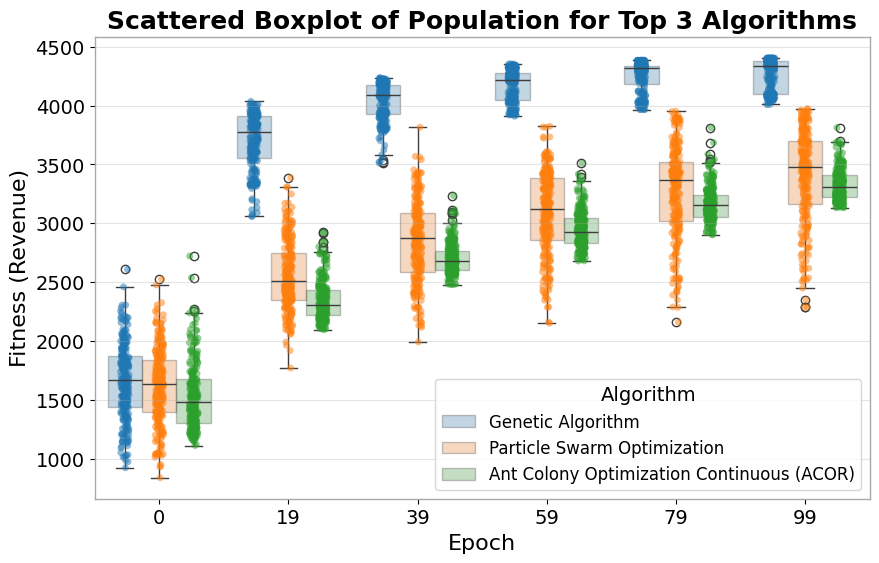

In [45]:
# Filter df, only rows with 'Iteration' values included in [0, .., 49]
df_boxplot_filtered = df_boxplot[df_boxplot['Iteration'].isin([0, 19, 39, 59, 79, 99])]

sns_box_plot(df=df_boxplot_filtered,
             x_data='Iteration',
             y_data='Fitness',
             hue='Algorithm',
             title="Scattered Boxplot of Population for Top 3 Algorithms",
             x_label="Epoch",
             y_label="Fitness (Revenue)",
             save_path=Path('../reports/mealpy/scattered_boxplot_top_3_25.pdf'))

In [55]:
df_gcc

,Run,Iteration,Fitness,ExecutionTime,Discrete,Real
0,1,0,2490.609101,0.245138,"[False, True, False, True, True, True, True, F...","[1066.0, 1113.0, 1140.0, 872.0, 970.0, 1048.0,..."
1,1,1,2735.944798,0.232498,"[False, True, False, True, True, False, True, ...","[1066.0, 1113.0, 1146.0, 871.0, 974.0, 1048.0,..."
2,1,2,2735.944798,0.241787,"[False, True, False, True, True, False, True, ...","[1066.0, 1113.0, 1146.0, 871.0, 974.0, 1048.0,..."
3,1,3,3118.945689,0.235366,"[False, True, False, True, True, True, True, F...","[1051.0, 1113.0, 1148.0, 872.0, 970.0, 1048.0,..."
4,1,4,3230.402017,0.272952,"[False, True, False, True, True, True, True, F...","[1066.0, 1113.0, 1148.0, 871.0, 970.0, 1052.0,..."
...,...,...,...,...,...,...
95,5,95,4378.600190,0.248237,"[False, True, False, True, True, True, True, F...","[1068.0, 1111.0, 1145.0, 871.0, 970.0, 1044.0,..."
96,5,96,4378.600190,0.249454,"[False, True, False, True, True, True, True, F...","[1068.0, 1111.0, 1145.0, 871.0, 970.0, 1044.0,..."
97,5,97,4378.600190,0.260521,"[False, True, False, True, True, True, True, F...","[1068.0, 1113.0, 1145.0, 871.0, 970.0, 1044.0,..."
98,5,98,4383.045238,0.251938,"[False, True, False, True, True, True, True, F...","[1068.0, 1111.0, 1145.0, 871.0, 970.0, 1044.0,..."


In [22]:
# Table with results by run

sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)

service_tsps = {service.id: service.tsp.name for service in supply.services}
columns = ['Algorithm', 'Run', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)']
columns += set(service_tsps.values())

summary_df = pd.DataFrame(columns=columns)

algo_grouped_df = df_history.groupby('Algo')

for algo_group in algo_grouped_df:
    run_grouped_df = algo_group[1].groupby('Run')
    for group in run_grouped_df.groups:
        run = run_grouped_df.get_group(group)['Run'].iloc[-1]
        revenue = np.round(run_grouped_df.get_group(group)['Fitness'].iloc[-1], 2)
        execution_time = np.round(run_grouped_df.get_group(group)['ExecutionTime'].sum(), 2)
        scheduled_trains_array = run_grouped_df.get_group(group)['Discrete'].iloc[-1]
        scheduled_trains = int(sum(run_grouped_df.get_group(group)['Discrete'].iloc[-1]))
        real_solution = run_grouped_df.get_group(group)['Real'].iloc[-1]
        sm.update_schedule(Solution(real=real_solution, discrete=scheduled_trains))
        delta_dt = 0.0
        delta_tt = 0.0
        services_by_tsp = {tsp: 0 for tsp in service_tsps.values()}
        for i, service in enumerate(sm.requested_schedule):
            if not scheduled_trains_array[i]:
                continue
            departure_station = list(sm.requested_schedule[service].keys())[0]
            delta_dt += abs(sm.updated_schedule[service][departure_station][1] -
                            sm.requested_schedule[service][departure_station][1])
            for j, stop in enumerate(sm.requested_schedule[service].keys()):
                if j == 0 or j == len(sm.requested_schedule[service]) - 1:
                    continue
                delta_tt += abs(sm.updated_schedule[service][stop][1] - sm.requested_schedule[service][stop][1])
    
            service_tsp = service_tsps[service]
            services_by_tsp[service_tsp] += 1
    
        percentages_by_tsp = {}
        for tsp in services_by_tsp:
            percentages_by_tsp[tsp] = f"{np.round(services_by_tsp[tsp] / tsp_df.loc[tsp, 'Number of Services'] * 100, 2)} %"
        row_data =  [algo_group[0], run, revenue, execution_time, 
                     scheduled_trains, np.round(delta_dt, 2), np.round(delta_tt, 2), *list(percentages_by_tsp.values())]
        summary_df.loc[len(summary_df)] = row_data

summary_df = summary_df.sort_values('Revenue', ascending=False)
display(summary_df)
print()

,Algorithm,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.),RU3,RU4,RU2,RU1
21,Genetic Algorithm,2,4407.02,25.41,18,20.00,20.00,50.0 %,80.0 %,50.0 %,100.0 %
22,Genetic Algorithm,3,4397.00,25.26,18,22.00,14.00,50.0 %,90.0 %,33.33 %,100.0 %
24,Genetic Algorithm,5,4394.21,26.33,19,34.00,37.00,50.0 %,80.0 %,66.67 %,100.0 %
23,Genetic Algorithm,4,4359.11,25.01,18,27.00,26.00,50.0 %,80.0 %,50.0 %,100.0 %
20,Genetic Algorithm,1,4348.73,24.98,18,22.00,33.00,50.0 %,80.0 %,50.0 %,100.0 %
35,Particle Swarm Optimization,1,3972.60,25.94,17,48.39,104.10,50.0 %,80.0 %,33.33 %,100.0 %
37,Particle Swarm Optimization,3,3951.24,25.11,17,36.46,99.85,50.0 %,80.0 %,50.0 %,80.0 %
1,Ant Colony Optimization Continuous (ACOR),2,3812.21,15.06,18,98.18,104.90,50.0 %,90.0 %,33.33 %,100.0 %
36,Particle Swarm Optimization,2,3806.60,25.11,17,54.25,97.19,50.0 %,80.0 %,50.0 %,80.0 %
39,Particle Swarm Optimization,5,3797.09,24.81,17,44.57,112.32,50.0 %,70.0 %,50.0 %,100.0 %


In [23]:
summary_df.to_latex()

'\\begin{tabular}{llrrrrrrllll}\n\\toprule\n & Algorithm & Run & Revenue & Execution Time (s.) & Scheduled Trains & Delta DT (min.) & Delta TT (min.) & RU3 & RU4 & RU2 & RU1 \\\\\n\\midrule\n21 & Genetic Algorithm & 2 & 4407.020000 & 25.410000 & 18 & 20.000000 & 20.000000 & 50.0 % & 80.0 % & 50.0 % & 100.0 % \\\\\n22 & Genetic Algorithm & 3 & 4397.000000 & 25.260000 & 18 & 22.000000 & 14.000000 & 50.0 % & 90.0 % & 33.33 % & 100.0 % \\\\\n24 & Genetic Algorithm & 5 & 4394.210000 & 26.330000 & 19 & 34.000000 & 37.000000 & 50.0 % & 80.0 % & 66.67 % & 100.0 % \\\\\n23 & Genetic Algorithm & 4 & 4359.110000 & 25.010000 & 18 & 27.000000 & 26.000000 & 50.0 % & 80.0 % & 50.0 % & 100.0 % \\\\\n20 & Genetic Algorithm & 1 & 4348.730000 & 24.980000 & 18 & 22.000000 & 33.000000 & 50.0 % & 80.0 % & 50.0 % & 100.0 % \\\\\n35 & Particle Swarm Optimization & 1 & 3972.600000 & 25.940000 & 17 & 48.390000 & 104.100000 & 50.0 % & 80.0 % & 33.33 % & 100.0 % \\\\\n37 & Particle Swarm Optimization & 3 & 3951.2

In [24]:
# Global status

def get_global_status(df: pd.DataFrame):
    algo_grouped_df = df.groupby('Algo')

    for algo_group in algo_grouped_df:
        run_grouped_df = algo_group[1].groupby('Run')
        
        print(f"Global {algo_group[0]} status:")
        
        # Execution time (mean and std.)
        run_times = run_grouped_df['ExecutionTime'].last()
        print(f'\tTotal execution time: {round(run_times.sum(), 4)} s.')
        print(f'\tExecution Time (by run) - Mean: {round(run_times.mean(), 4)} s. - Std: {round(run_times.std(), 4)} s.')
        
        # Revenue (mean and std.)
        run_revenues = run_grouped_df['Fitness'].last()
        print(f'\tRevenue - Mean: {round(run_revenues.mean(), 4)} - Std: {round(run_revenues.std(), 4)}')
        
        # Scheduled trains (mean and std.)
        run_trains = run_grouped_df['Discrete'].last().apply(sum)
        print(f'\tScheduled Trains - Mean: {np.round(run_trains.mean())} - Std: {np.round(run_trains.std())}')
        
        max_revenue = sum([sm.revenue[service]['canon'] for service in sm.revenue])
        print(f"\tMax Revenue: {max_revenue} - WARNING!: Scheduling all services could not be feasible")
        print()
        
get_global_status(df_history)

Global Ant Colony Optimization Continuous (ACOR) status:
	Total execution time: 0.7536 s.
	Execution Time (by run) - Mean: 0.1507 s. - Std: 0.0018 s.
	Revenue - Mean: 3691.8869 - Std: 80.8428
	Scheduled Trains - Mean: 18.0 - Std: 0.0
	Max Revenue: 5824.5 - WARNING!: Scheduling all services could not be feasible

Global Artificial Bee Colony status:
	Total execution time: 2.4728 s.
	Execution Time (by run) - Mean: 0.4946 s. - Std: 0.0078 s.
	Revenue - Mean: 3438.3921 - Std: 83.7139
	Scheduled Trains - Mean: 17.0 - Std: 1.0
	Max Revenue: 5824.5 - WARNING!: Scheduling all services could not be feasible

Global Covariance Matrix Adaptation Evolution Strategy status:
	Total execution time: 2.5353 s.
	Execution Time (by run) - Mean: 0.5071 s. - Std: 0.0614 s.
	Revenue - Mean: 3230.208 - Std: 141.9329
	Scheduled Trains - Mean: 15.0 - Std: 0.0
	Max Revenue: 5824.5 - WARNING!: Scheduling all services could not be feasible

Global Differential Evolution status:
	Total execution time: 1.2516 s.
	

In [25]:

def get_global_status_as_dataframe(df: pd.DataFrame):
    algo_grouped_df = df.groupby('Algo')
    
    results = []
    for algo_name, algo_group in algo_grouped_df:
        run_grouped_df = algo_group.groupby('Run')
        
        run_times = run_grouped_df['ExecutionTime'].sum()
        
        run_revenues = run_grouped_df['Fitness'].last()
        run_trains = run_grouped_df['Discrete'].last().apply(sum)
        
        result = {
            'Algorithm': algo_name,
            'Mean Execution Time (seconds)': round(run_times.mean(), 2),
            'Std Execution Time (seconds)': round(run_times.std(), 2),
            'Mean Fitness (revenue)': round(run_revenues.mean(), 2),
            'Std Fitness (revenue)': round(run_revenues.std(), 2),
            'Mean Scheduled Trains': int(round(run_trains.mean())),
            'Std Scheduled Trains': int(round(run_trains.std()))
        }
        
        results.append(result)
    
    results_df = pd.DataFrame(results)
    
    # Short by column 'Mean Fitness' 
    results_df = results_df.sort_values(by='Mean Fitness (revenue)', ascending=False).reset_index(drop=True)
    return results_df

results_df = get_global_status_as_dataframe(df_history)
results_df

,Algorithm,Mean Execution Time (seconds),Std Execution Time (seconds),Mean Fitness (revenue),Std Fitness (revenue),Mean Scheduled Trains,Std Scheduled Trains
0,Genetic Algorithm,25.40,0.55,4381.21,25.63,18,0
1,Particle Swarm Optimization,25.14,0.48,3845.48,114.46,17,0
2,Ant Colony Optimization Continuous (ACOR),15.11,0.08,3691.89,80.84,18,0
3,Whale Optimization Algorithm,25.01,0.29,3554.28,30.63,15,0
4,Differential Evolution,25.14,0.15,3463.48,238.22,17,1
5,Artificial Bee Colony,50.03,0.26,3438.39,83.71,17,1
6,Covariance Matrix Adaptation Evolution Strategy,52.13,1.88,3230.21,141.93,15,0
7,Grey Wolf Optimizer,24.79,0.09,3112.63,399.35,16,1
8,Hybrid Grey Wolf - Whale Optimization Algorithm,24.98,0.22,2703.05,56.95,16,1
9,Simulated Annealing,26.00,0.27,2464.85,384.82,15,1


In [26]:
results_df.to_latex()

'\\begin{tabular}{llrrrrrr}\n\\toprule\n & Algorithm & Mean Execution Time (seconds) & Std Execution Time (seconds) & Mean Fitness (revenue) & Std Fitness (revenue) & Mean Scheduled Trains & Std Scheduled Trains \\\\\n\\midrule\n0 & Genetic Algorithm & 25.400000 & 0.550000 & 4381.210000 & 25.630000 & 18 & 0 \\\\\n1 & Particle Swarm Optimization & 25.140000 & 0.480000 & 3845.480000 & 114.460000 & 17 & 0 \\\\\n2 & Ant Colony Optimization Continuous (ACOR) & 15.110000 & 0.080000 & 3691.890000 & 80.840000 & 18 & 0 \\\\\n3 & Whale Optimization Algorithm & 25.010000 & 0.290000 & 3554.280000 & 30.630000 & 15 & 0 \\\\\n4 & Differential Evolution & 25.140000 & 0.150000 & 3463.480000 & 238.220000 & 17 & 1 \\\\\n5 & Artificial Bee Colony & 50.030000 & 0.260000 & 3438.390000 & 83.710000 & 17 & 1 \\\\\n6 & Covariance Matrix Adaptation Evolution Strategy & 52.130000 & 1.880000 & 3230.210000 & 141.930000 & 15 & 0 \\\\\n7 & Grey Wolf Optimizer & 24.790000 & 0.090000 & 3112.630000 & 399.350000 & 16 & 1

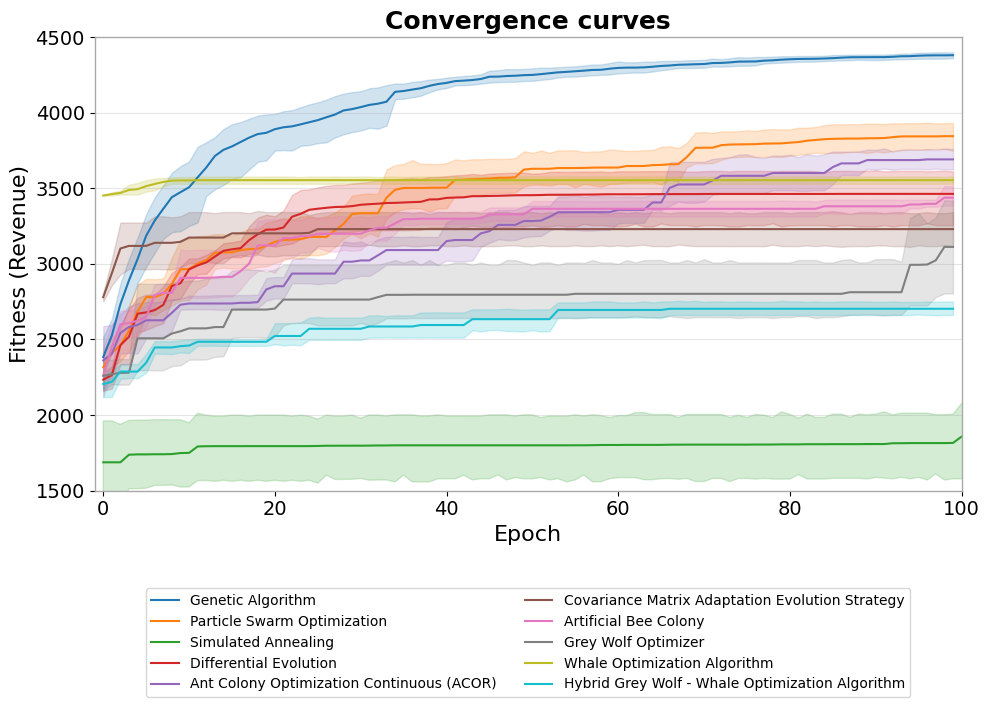

In [33]:
sns_line_plot(df=df_history,
              x_data="Iteration",
              y_data="Fitness",
              hue="Algo",
              title="Convergence curves",
              x_label="Epoch",
              y_label="Fitness (Revenue)",
              x_limit=(-1, 100),
              y_limit=(1500,4500),
              save_path=Path('../reports/mealpy/mealpy_convergence_5_seed.pdf'),
              fig_size=(10, 9))

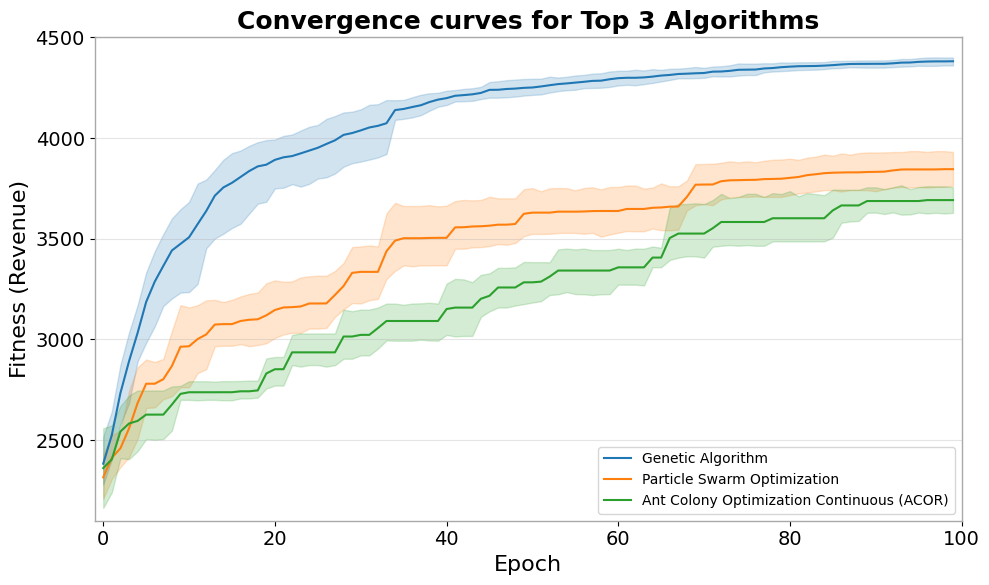

In [52]:
top_3_algos = ("Genetic Algorithm",
               "Particle Swarm Optimization",
               "Ant Colony Optimization Continuous (ACOR)")

# Create dataframe with fitness values for each individual of the population
df_history_top_3 = df_history[df_history['Algo'].isin(top_3_algos)]

sns_line_plot(df=df_history_top_3,
              x_data="Iteration",
              y_data="Fitness",
              hue="Algo",
              title="Convergence curves for Top 3 Algorithms",
              x_label="Epoch",
              y_label="Fitness (Revenue)",
              x_limit=(-1, 100),
              y_limit=(2100,4500),
              save_path=Path('../reports/mealpy/mealpy_convergence_5_seed_top_3.pdf'),
              fig_size=(10, 7))

In [35]:
from scipy import stats

# Filtrar el dataframe por cada algoritmo
genetic_algorithm_df = df_history[df_history['Algo'] == 'Genetic Algorithm']
acor_algorithm_df = df_history[df_history['Algo'] == 'Ant Colony Optimization Continuous (ACOR)']

# Calcular la media de 'Revenue' por cada ejecución (Run) para el algoritmo genético
genetic_revenues_mean = genetic_algorithm_df.groupby('Run')['Fitness'].mean().tolist()

# Calcular la media de 'Revenue' por cada ejecución (Run) para el algoritmo ACOR
acor_revenues_mean = acor_algorithm_df.groupby('Run')['Fitness'].mean().tolist()

# Mostrar las listas
print("Genetic Algorithm Revenue Means:", genetic_revenues_mean)
print("ACOR Revenue Means:", acor_revenues_mean)

Genetic Algorithm Revenue Means: [4145.998711723439, 4026.433919456497, 4174.7407553455805, 4168.648426960138, 4190.514872609186]
ACOR Revenue Means: [3221.930543562657, 3092.1996934658923, 3175.4692325854876, 3259.7421323824474, 3187.064052365891]


In [36]:
stat, p_value = stats.wilcoxon(genetic_revenues_mean, acor_revenues_mean)
print(f"Estadístico de Wilcoxon: {stat}, Valor p: {p_value}")

Estadístico de Wilcoxon: 0.0, Valor p: 0.0625


In [37]:
# Select a solution from df_history:
algo_name = 'Genetic Algorithm'
run = 5
iteration = 99

filtered_row = df_history[
    (df_history["Algo"] == algo_name) &
    (df_history["Run"] == run) &
    (df_history["Iteration"] == iteration)
]

# Get values from columns "Real" & "Discrete"
if not filtered_row.empty:
    real_value = filtered_row["Real"].iloc[0]
    discrete_value = filtered_row["Discrete"].iloc[0]
    ga_best_sol = Solution(real=real_value, discrete=discrete_value)
    print(f"Real: {real_value}, Discrete: {discrete_value}")
else:
    print("Row not found matching the provided parameters.")

Real: [1065. 1112. 1142.  873.  972. 1046.  907.  828.  913. 1355.  731.  130.
  210.  271.  479.  531.  630.  693.  930.  748.  177.  399.  463.  506.
  939.  968. 1038. 1094. 1132. 1161. 1188. 1253. 1309. 1345.  422.  466.
  503.  278.  336.  374.  528.  570. 1070. 1190. 1249. 1288.  559.  613.
  649. 1241.  462.  525.  567. 1276.  898.  998. 1060.], Discrete: [False  True False  True  True  True  True False  True False  True  True
  True  True  True False  True False  True  True  True  True  True  True
  True]


In [25]:
sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)

services = sm.update_supply(path=generator_save_path,
                            solution=ga_best_sol)

sm.update_schedule(solution=ga_best_sol)

filtered_services = {}
for i, service in enumerate(sm.updated_schedule):
    if ga_best_sol.discrete[i]:
        filtered_services[service] = sm.updated_schedule[service]

#plotter = TrainSchedulePlotter(filtered_services, line)
#plotter.plot(plot_security_gaps=True, save_path=Path('../figures/updated.pdf'))

tt_file_name = f'{supply_config_path.stem}_gsa'
print(supply_save_path, tt_file_name)
SupplySaver(services).to_yaml(filename=f'{tt_file_name}.yml', save_path=supply_save_path)

# Copy previous file in reports
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'gsa/{tt_file_name}_25_new.yml')

supply_config_file = Path(f'{supply_save_path}{tt_file_name}.yml')

../configs/mealpy/ supply_config_gsa


In [26]:
final_supply = Supply.from_yaml(supply_config_file)

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


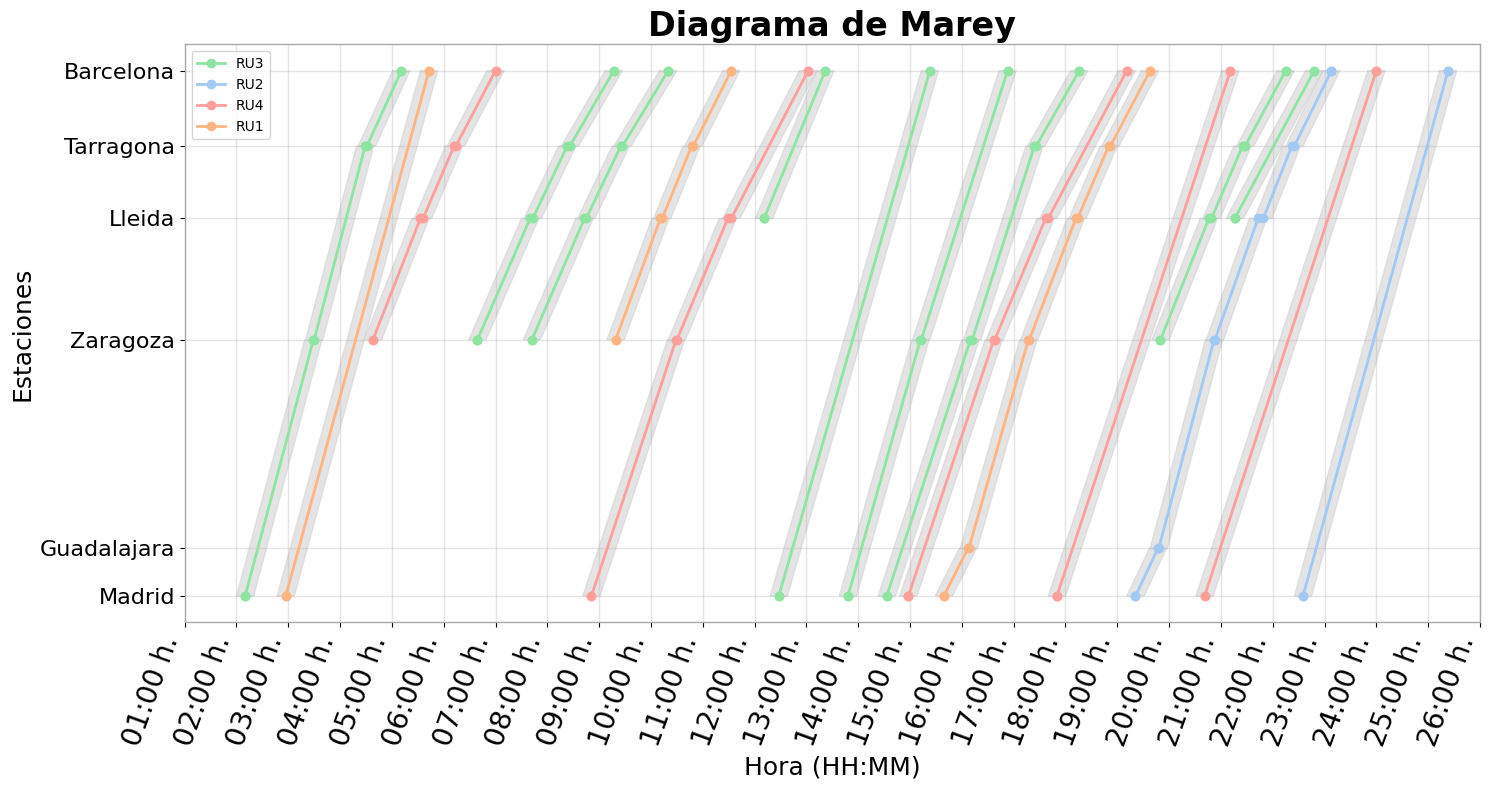

In [27]:
plot_marey_chart(requested_supply=final_supply,
                 colors_by_tsp=True, 
                 main_title="Diagrama de Marey",
                 plot_security_gaps=True,
                 security_gap=10,
                 save_path=Path('../reports/mealpy/marey_chart_ga_25.pdf'))

In [38]:
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'mealpy/{tt_file_name}_25.yml')

PosixPath('../reports/mealpy/supply_config_gsa_25.yml')

In [30]:
#!snakeviz profile.pstat